**This is the 2nd model iteration. The 1st model was attempting to use transfer learning from ImageNet, but only achieved ~42% accuracy. Also I was using a colour model to predict on grayscale images with is a bit inefficient. The state of the art is over 70%, so I want to try to get a simple CNN model without transfer learning over say 60% accuracy.

## Introduction
A quick model to classify emotion in faces. This model is intended to be used for the Capstone Project in the Udacity C++ Nanodegree. The idea is first to build a working model using Keras/Tensorflow in Python, without worrying too much about optimising performance since the aim of this project is to showcase C++ programming. Then we will save the model checkpoints and deploy it for model inference using C++. 

## Model and Data Summary
- Data: Facial Emotion Recognition Dataset (FER) https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
- Model Architecture: MobileNetV2 (lightweight for real-time)
- Pre-trained Model using ImageNet weights, fine-tuned to FER dataset  

**Note:** Model building process is very similar to this face mask detector transfer learning tutorial https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/, but just applying to the new dataset. However I am not using the Python API of OpenCV, I will be saving the model checkpoints and then deploying using the OpenCV and Tensorflow C++ APIs.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir
path = base_dir

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pandas as pd

LR = 1e-4
EPOCHS = 1000
BATCH_SIZE = 256

## Data Pre-processing and Augmentation

In [8]:
# Read in csv of pixel vectors, then convert to 48x48 numpy arrays
# Also make np array of labels
raw_data = pd.read_csv(path+"data/icml_face_data.csv")
raw_data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [9]:
raw_np = raw_data.values
raw_np.shape

(35887, 3)

In [0]:
images = np.array([np.reshape([int(s) for s in pic.split(' ')], (48,48)) for pic in raw_np[:,2]])/255.0
labels = raw_np[:,0].astype('int')

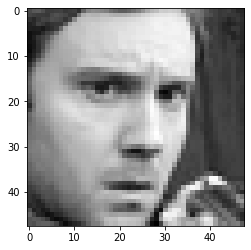

In [11]:
plt.imshow(images[0], cmap='gray')

In [0]:
# Split Train, Test, Val
train_images = images[raw_np[:,1]=="Training"][...,np.newaxis]
valid_images = images[raw_np[:,1]=="PublicTest"][...,np.newaxis]
test_images = images[raw_np[:,1]=="PrivateTest"][...,np.newaxis]

train_labels = labels[raw_np[:,1]=="Training"]
valid_labels = labels[raw_np[:,1]=="PublicTest"]
test_labels = labels[raw_np[:,1]=="PrivateTest"]

In [13]:
train_labels

array([0, 0, 2, ..., 4, 0, 4])

In [14]:
train_images.shape

(28709, 48, 48, 1)

## Keras Image Data Generator

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


## Model Structure

In [0]:
inputs = Input(shape=(48,48,1))
X = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
X = MaxPooling2D(pool_size=(2,2))(X)
X = Dropout(0.25)(X)

X = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(X)
X = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2,2))(X)
X = Dropout(0.25)(X)

X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.5)(X)
outputs = Dense(7, activation='softmax')(X)

model = Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0     

## Train Model

In [0]:
# From https://www.kaggle.com/rivesunder/optimizing-learning-rate-in-keras
class lr_finder():
    
    def __init__(self,model,begin_lr=1e-8, end_lr=1e-1, num_epochs=10, period=5):
        # lr_finder generates learning schedules for finding upper and lower bounds on the best learning rate, as well as 
        # a cyclical learning rate schedule based on those bounds
        self.period = period
        # make a copy of the model to train through a sweep of learning rates
        self.model = clone_model(model)
        
        # define bounds to sweep through
        self.begin_lr = np.log(begin_lr)/np.log(10)
        self.end_lr = np.log(end_lr)/np.log(10)
        self.num_epochs = num_epochs
        self.lower_bound = begin_lr
        self.upper_bound = 1e-2 #end_lr
        # define learning rates to use in schedules
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)
        
        
    def reset_model(self, model):
        # reset the model to find new lr bounds 
        self.begin_lr = -10 
        self.end_lr = 0 
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.model = clone_model(model)
        
    def lr_schedule(self,epoch):
        # return lr according to a sweeping schedule
        if epoch < self.num_epochs:
            return self.lr[epoch]
        else:
            return self.lr[0]
        
    def clr_schedule(self,epoch,period=5):
        # return lr according to cyclical learning rate schedule
        my_epoch = int(epoch % self.period)
        return self.clr[my_epoch]
    
    def lr_vector(self,epochs):
        # return the vector of learning rates used in a schedule
        lrv = []
        for ck in range(epochs):
            lrv.append(self.lr_schedule(ck))
        return lrv
    
    def lr_plot(self,history_loss,please_plot=True):
        # plot the lr sweep results and set upper and lower bounds on learning rate
        x_axis = self.lr_vector(self.num_epochs)
        y_axis = history_loss
                   
        d_loss = []
        for cc in range(1,len(y_axis)):
            if cc == 1:
                d_loss.append(y_axis[cc] - y_axis[cc-1])
            else:
                d_loss.append(0.8*(y_axis[cc] - y_axis[cc-1])+0.2*(y_axis[cc-1] - y_axis[cc-2]))
        d_loss = np.array(d_loss)
        
        self.lower_bound = x_axis[d_loss.argmin()]
        self.upper_bound = x_axis[np.array(y_axis).argmin()]
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)
        
        print("recommended learning rate: more than %.2e, less than %.2e "%(self.lower_bound, self.upper_bound))
        if(please_plot):
            plt.figure(figsize=(10,5))
            plt.loglog(x_axis,y_axis)
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.title('Loss / learning rate progression')
            plt.show()
            
    def get_lr(self,epoch):
        # return the geometric mean of the upper and lower bound learning rates
        return (self.lower_bound *self.upper_bound)**(1/2)

In [0]:
# initialize learning rate finder callback

lrf = lr_finder(model,begin_lr=1e-8, end_lr=1e0, num_epochs=20)
lr_rate = LearningRateScheduler(lrf.lr_schedule)

In [0]:
steps_per_epoch = int(len(train_labels)/BATCH_SIZE)
max_epochs = 20

lrf.model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])


lr_history = lrf.model.fit(datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE),
                                steps_per_epoch=steps_per_epoch/20,
                                validation_data=(valid_images, valid_labels),
                                validation_steps=50,
                                epochs=max_epochs,
                                callbacks=[lr_rate],
                                verbose=0)

recommended learning rate: more than 2.07e-02, less than 7.85e-03 


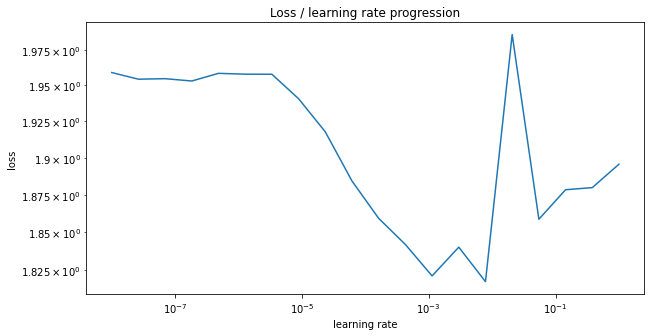

In [21]:
lrf.lr_plot(lr_history.history['loss']) # probably use ~1e-4? (apparently 3e-4 is a rule of thumb that works well alot of the time; could also use a lr decay starting from 1e-3)

In [0]:
opt = Adam(lr=3e-4)
model.compile(optimizer=opt,
              loss="sparse_categorical_crossentropy", # sparse means the label input was just a vector of classes from 0-6
              metrics=["accuracy"])
history = model.fit(datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE), 
          steps_per_epoch=len(train_images) // BATCH_SIZE,
          validation_data=(valid_images, valid_labels),
          validation_steps=len(valid_images) // BATCH_SIZE,
          epochs=EPOCHS)#,
          # callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=50)])

Epoch 1/1000
112/112 [==============================] - 14s 121ms/step - loss: 1.8258 - accuracy: 0.2425 - val_loss: 1.8237 - val_accuracy: 0.2491
Epoch 2/1000
112/112 [==============================] - 14s 121ms/step - loss: 1.7932 - accuracy: 0.2544 - val_loss: 1.7983 - val_accuracy: 0.2806
Epoch 3/1000
112/112 [==============================] - 13s 118ms/step - loss: 1.7817 - accuracy: 0.2570 - val_loss: 1.7690 - val_accuracy: 0.2898
Epoch 4/1000
112/112 [==============================] - 13s 118ms/step - loss: 1.7754 - accuracy: 0.2658 - val_loss: 1.7488 - val_accuracy: 0.3004
Epoch 5/1000
112/112 [==============================] - 13s 120ms/step - loss: 1.7662 - accuracy: 0.2687 - val_loss: 1.7323 - val_accuracy: 0.3174
Epoch 6/1000
112/112 [==============================] - 13s 119ms/step - loss: 1.7560 - accuracy: 0.2769 - val_loss: 1.7251 - val_accuracy: 0.3132
Epoch 7/1000
112/112 [==============================] - 14s 121ms/step - loss: 1.7487 - accuracy: 0.2815 - val_loss: 1

## Check Model Performance

In [112]:
predIdxs = model.predict(test_images, batch_size=BATCH_SIZE)
print(classification_report(test_labels, np.argmax(predIdxs, axis=1)))
# model.save(path+'model_1', save_format="h5")

              precision    recall  f1-score   support

           0       0.51      0.58      0.54       491
           1       0.73      0.20      0.31        55
           2       0.48      0.32      0.38       528
           3       0.81      0.89      0.85       879
           4       0.52      0.44      0.47       594
           5       0.72      0.76      0.74       416
           6       0.56      0.69      0.62       626

    accuracy                           0.63      3589
   macro avg       0.62      0.55      0.56      3589
weighted avg       0.62      0.63      0.61      3589



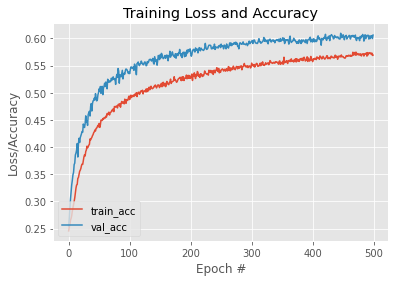

In [113]:
# plot the training loss and accuracy
N = 500
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


## Save Model Checkpoints

In [114]:
model.save(path+'model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/model/assets


In [0]:
loaded_model = load_model(path+"model")

In [116]:
loaded_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 32)        0   

In [0]:
test_pred = model.predict(test_images)

In [118]:
np.argmax(test_pred,axis=1)

array([0, 4, 2, ..., 3, 3, 4])

In [119]:
test_pred

array([[0.4709587 , 0.02884581, 0.10976511, ..., 0.17412287, 0.01634385,
        0.1995263 ],
       [0.18726961, 0.007482  , 0.09983738, ..., 0.3266488 , 0.03470417,
        0.22697578],
       [0.16134587, 0.00063865, 0.43879196, ..., 0.30328554, 0.00566304,
        0.08043552],
       ...,
       [0.14399879, 0.00481411, 0.21197751, ..., 0.20891005, 0.05039275,
        0.15105268],
       [0.04355081, 0.00093334, 0.00769306, ..., 0.02101481, 0.00207024,
        0.03655706],
       [0.15557905, 0.01416554, 0.22377592, ..., 0.41860834, 0.00291206,
        0.18420745]], dtype=float32)